**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: Proyecto Integrador -TC5035**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

Avance 4. Modelos alternativos

**- Equipo 37** <p>Perla Fernanda Bazán Barajas<p> Ignacio Garay Ruíz<p> David Cruz Beltrán

**- Matrículas** <p>A01420700<p> A01795753<p> A01360416

# Introducción

En este avance del proyecto FlexSAIze, nos enfocaremos en explorar distintas técnicas de modelado con el objetivo de identificar cuáles ofrecen el mejor desempeño para resolver el reto de adaptar automáticamente layouts publicitarios a múltiples formatos. A partir del dataset que hemos venido construyendo y enriqueciendo, desarrollamos seis modelos individuales utilizando algoritmos variados, con el fin de comparar su rendimiento en términos de precisión, eficiencia y capacidad de generalización.
<p>
Posteriormente, seleccionamos los dos modelos con mejor desempeño para realizar un proceso de ajuste de hiperparámetros que nos permitiera optimizar sus resultados. Esta etapa no solo nos ayudó a comprender mejor el comportamiento de cada enfoque, sino que también nos permitió avanzar hacia una solución más robusta, que responda adecuadamente a las necesidades creativas y operativas planteadas por PepsiCo.
<p>
Este ejercicio representa un paso importante dentro del desarrollo técnico del proyecto, al sentar una base sólida para la elección del modelo final que será utilizado en futuras fases de implementación.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# Aquí cada quien tiene que agregar el acceso directo de su carpeta compartida a su unidad de Drive
# Después poner la ruta correcta dependiendo del paso anterior
# DIR = "/content/drive/MyDrive/14. Proyecto integrador/Banners/CSV"
DIR = "/content/drive/MyDrive/14. Proyecto integrador/Banners/CSV"
os.chdir(DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

# Preprocesamiento de Datos

In [4]:
df = pd.read_csv("banners_metadata_4.csv")
df.head()

,file,layer_name,type,priority,x,y,width,height,z_index,canvas_width,canvas_height,kv_canvas_width,kv_canvas_height,kv_x,kv_y,kv_width,kv_height,kv_z_index,is_in_kv
0,Bubly_KV.psd,BACKGROUND,BACKGROUND,-1,0,0,1706,1706,0,1706,1706,1706.0,1706.0,0.0,0.0,1706.0,1706.0,0.0,1
1,Bubly_KV.psd,SUB HEADING,TEXT,2,381,1341,910,146,1,1706,1706,1706.0,1706.0,381.0,1341.0,910.0,146.0,1.0,1
2,Bubly_KV.psd,COPY,TEXT,2,172,219,1361,162,2,1706,1706,1706.0,1706.0,172.0,219.0,1361.0,162.0,2.0,1
3,Bubly_KV.psd,SKUs,PRODUCT,2,232,523,1273,570,3,1706,1706,1706.0,1706.0,232.0,523.0,1273.0,570.0,3.0,1
4,FoodService_KV.psd,BACKGROUND,BACKGROUND,-1,0,0,1298,1080,0,1298,1080,1298.0,1080.0,0.0,0.0,1298.0,1080.0,0.0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file              906 non-null    object 
 1   layer_name        906 non-null    object 
 2   type              906 non-null    object 
 3   priority          906 non-null    int64  
 4   x                 906 non-null    int64  
 5   y                 906 non-null    int64  
 6   width             906 non-null    int64  
 7   height            906 non-null    int64  
 8   z_index           906 non-null    int64  
 9   canvas_width      906 non-null    int64  
 10  canvas_height     906 non-null    int64  
 11  kv_canvas_width   694 non-null    float64
 12  kv_canvas_height  694 non-null    float64
 13  kv_x              600 non-null    float64
 14  kv_y              600 non-null    float64
 15  kv_width          600 non-null    float64
 16  kv_height         600 non-null    float64
 1

In [6]:
df_transformado = df.copy()

# Nuevas variables: relative_area y aspect_ratio (banner y KV)
# Banner (siempre definidas)

df_transformado["aspect_ratio"]  = df_transformado["width"] / df_transformado["height"]
df_transformado["relative_area"] = (df_transformado["width"] * df_transformado["height"]) / (
    df_transformado["canvas_width"] * df_transformado["canvas_height"]
)

# KV (solo cuando hay datos)

df_transformado["kv_aspect_ratio"] = df_transformado["kv_width"] / df_transformado["kv_height"]
df_transformado["kv_relative_area"] = (df_transformado["kv_width"] * df_transformado["kv_height"]) / (
    df_transformado["kv_canvas_width"] * df_transformado["kv_canvas_height"]
)

# Colocar NaN en KV cuando falte algo o is_in_kv == 0

kv_base_cols = ["kv_x","kv_y","kv_width","kv_height","kv_canvas_width","kv_canvas_height","kv_z_index"]
kv_derived_cols = ["kv_aspect_ratio","kv_relative_area"]
kv_all_cols = kv_base_cols + kv_derived_cols

mask_kv_invalida = (df_transformado["is_in_kv"] == 0) | df_transformado[kv_base_cols].isna().any(axis=1)
df_transformado.loc[mask_kv_invalida, kv_all_cols] = np.nan

# Eliminamos todas las instancias de BACKGROUND que no aportan información al modelo

df_transformado = df_transformado[df_transformado["layer_name"] != "Background"]

# Label encoding de 2 categóricas: layer_name, type
# Quitamos 'file' porque solo sirve como identificador, pero antes lo guardamos en una variable "grupos"

grupos = df["file"]

df_transformado.drop(columns=["file"], inplace=True)

cat_cols = ["layer_name", "type"]
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    # Ajustar solo sobre valores no nulos
    df_transformado[col] = le.fit_transform(df_transformado[col].astype(str))
    label_encoders[col] = le

# Yeo-Johnson + MinMax(0,1) a numéricas "aplicables"
#    (excluimos tamaños absolutos de canvas y de KV por su naturaleza discreta/absoluta)
excluir_transform = {
    "canvas_width","canvas_height","kv_canvas_width","kv_canvas_height",
    "priority","z_index","kv_z_index"
}

# Columnas numéricas actuales
num_cols = df_transformado.select_dtypes(include=["number"]).columns.tolist()

# No transformar dummies ni las de exclusión
cols_a_transformar = [
    c for c in num_cols
    if (c not in excluir_transform) and (c not in cat_cols)
]

# Transformación columna a columna, preservando NaN
for col in cols_a_transformar:
    serie = df_transformado[col]
    mask = serie.notna()

    # Si hay al menos dos valores para ajustar
    if mask.sum() >= 2:
        # Yeo-Johnson sin estandarizar (solo "desinclina")
        pt = PowerTransformer(method="yeo-johnson", standardize=False)
        vals_pt = pt.fit_transform(serie[mask].to_numpy().reshape(-1, 1))

        # Min-Max a [0,1]
        mm = MinMaxScaler()
        vals_scaled = mm.fit_transform(vals_pt).ravel()

        # Reemplazar manteniendo NaN
        df_transformado.loc[mask, col] = vals_scaled


# Verificación rápida
print("Shape final:", df_transformado.shape)
df_transformado.info()


Shape final: (906, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   layer_name        906 non-null    int64  
 1   type              906 non-null    int64  
 2   priority          906 non-null    int64  
 3   x                 906 non-null    float64
 4   y                 906 non-null    float64
 5   width             906 non-null    float64
 6   height            906 non-null    float64
 7   z_index           906 non-null    int64  
 8   canvas_width      906 non-null    int64  
 9   canvas_height     906 non-null    int64  
 10  kv_canvas_width   600 non-null    float64
 11  kv_canvas_height  600 non-null    float64
 12  kv_x              600 non-null    float64
 13  kv_y              600 non-null    float64
 14  kv_width          600 non-null    float64
 15  kv_height         600 non-null    float64
 16  kv_z_index        600

In [7]:
df_transformado.head()

,layer_name,type,priority,x,y,width,height,z_index,canvas_width,canvas_height,...,kv_x,kv_y,kv_width,kv_height,kv_z_index,is_in_kv,aspect_ratio,relative_area,kv_aspect_ratio,kv_relative_area
0,0,0,-1,0.517812,0.650798,0.779832,0.872615,0,1706,1706,...,0.490093,0.659055,0.951526,0.947282,0.0,1,0.335606,0.894187,0.435912,0.996724
1,9,7,2,0.567188,0.919896,0.698179,0.533783,1,1706,1706,...,0.673813,0.997390,0.724934,0.267499,1.0,1,0.734976,0.130355,0.832599,0.127277
2,1,7,2,0.545657,0.702679,0.750806,0.548836,2,1706,1706,...,0.597955,0.783085,0.864261,0.284667,2.0,1,0.789011,0.206615,0.874271,0.203404
3,8,6,2,0.552373,0.765253,0.742148,0.725954,3,1706,1706,...,0.621980,0.860717,0.839741,0.561137,3.0,1,0.515972,0.510997,0.633115,0.523300
4,0,0,-1,0.517812,0.650798,0.744671,0.812319,0,1298,1080,...,0.490093,0.659055,0.846816,0.765370,0.0,1,0.375318,0.894187,0.481695,0.996724


# Particiones

In [8]:
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GroupShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

In [9]:
# Definimos "X" y "y"
y_cols = ["x", "y", "width", "height"]
X = df_transformado.drop(columns=y_cols)
y = df_transformado[y_cols].copy()

In [10]:
# Tomamos los grupos desde el df original, alineados al índice de df_transformado
groups = df.loc[X.index, "file"]

# ---------- 1) 80% train vs 20% temp (group-aware) ----------
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, temp_idx = next(gss1.split(X, y, groups))

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
groups_train = groups.iloc[train_idx]

X_temp  = X.iloc[temp_idx]
y_temp  = y.iloc[temp_idx]
groups_temp = groups.iloc[temp_idx]

# ---------- 2) Del 20% restante → 10% val y 10% test ----------
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups_temp))

X_val  = X_temp.iloc[val_idx]
y_val  = y_temp.iloc[val_idx]
groups_val = groups_temp.iloc[val_idx]

X_test = X_temp.iloc[test_idx]
y_test = y_temp.iloc[test_idx]
groups_test = groups_temp.iloc[test_idx]

In [11]:
def uniq_files(g): return g.nunique()
print("Shapes -> Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)
print("Files únicos -> Train:", uniq_files(groups_train),
      "| Val:", uniq_files(groups_val), "| Test:", uniq_files(groups_test))

# Asegurar que no haya fuga de banners entre splits
inter_tr_val  = set(groups_train) & set(groups_val)
inter_tr_test = set(groups_train) & set(groups_test)
inter_val_test= set(groups_val)  & set(groups_test)
print("Intersecciones de 'file' (deben ser vacías):",
      len(inter_tr_val), len(inter_tr_test), len(inter_val_test))

Shapes -> Train: (720, 18) | Val: (93, 18) | Test: (93, 18)
Files únicos -> Train: 129 | Val: 16 | Test: 17
Intersecciones de 'file' (deben ser vacías): 0 0 0


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def report_metrics(y_true, y_pred, tag):
    """
    Calcula RMSE, MAE y R² promedio para modelos multi-output.
    Retorna tuple (rmse_mean, mae_mean, r2_mean) y un DataFrame por salida.
    """

    mae_vals  = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    rmse_vals = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    r2_vals   = r2_score(y_true, y_pred, multioutput='raw_values')

    # Promedios globales
    mae_mean = mae_vals.mean()
    rmse_mean = rmse_vals.mean()
    r2_mean = r2_vals.mean()

    # Mostrar resumen global
    print(f"[{tag}] RMSE(mean): {rmse_mean:.4f} | MAE(mean): {mae_mean:.4f} | R2(mean): {r2_mean:.4f}")

    # Detectar nombres de columnas si es DataFrame
    if isinstance(y_true, pd.DataFrame):
        col_names = y_true.columns
    else:
        col_names = [f"Output {i+1}" for i in range(len(mae_vals))]

    # Mostrar métricas individuales
    for name, m, r, s in zip(col_names, mae_vals, rmse_vals, r2_vals):
        print(f"   {name}: RMSE={r:.4f} | MAE={m:.4f} | R2={s:.4f}")

    df_metrics = pd.DataFrame({
        "Modelo": tag,
        "Variable": col_names,
        "RMSE": rmse_vals,
        "MAE": mae_vals,
        "R2": r2_vals
    })

    return (rmse_mean, mae_mean, r2_mean, df_metrics)


# Modelos

## 1. DecisionTreeRegressor

Como punto de partida para este análisis, retomamos el modelo desarrollado en la entrega anterior, donde se utilizó un árbol de decisión como algoritmo baseline. Este enfoque inicial nos permitió evaluar la viabilidad del problema y entender qué tan bien podían predecirse variables como posición y tamaño de los elementos visuales dentro de un banner, a partir de datos estructurados.

El modelo baseline mostró un desempeño sólido en la predicción de variables como height y width, alcanzando valores de R² superiores al 0.85, lo que indica una buena capacidad para capturar patrones relacionados con dimensiones. Sin embargo, la predicción de la posición horizontal (x) representó un mayor reto, con resultados más modestos en validación, aunque con señales de mejora en test.

Además, el árbol de decisión nos ofreció interpretabilidad, permitiéndonos identificar qué variables tienen mayor peso en cada predicción, lo cual fue especialmente útil para validar que las decisiones del modelo estaban alineadas con criterios de diseño visual y jerarquía de marca.

Este modelo base sirvió como referencia para evaluar el desempeño de los modelos adicionales desarrollados en este avance. A partir de sus resultados, buscamos mejorar la precisión, generalización y capacidad predictiva mediante algoritmos más complejos y técnicas de ajuste fino, sin perder de vista la claridad en la toma de decisiones que nos ofreció el árbol de decisión.

In [13]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [14]:
dtr = DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=5,
        random_state=42
    )

dtr.fit(X_train, y_train)

y_pred_val = dtr.predict(X_val)
y_pred_test = dtr.predict(X_test)

In [15]:
rmse_val_DTR, mae_val_DTR, r2_val_DTR, df_val_DTR = report_metrics(y_val,  y_pred_val,  "DTR VAL")
rmse_test_DTR, mae_test_DTR, r2_test_DTR, df_test_DTR = report_metrics(y_test, y_pred_test, "DTR TEST")
df_val_DTR["Dataset"] = "val"
df_test_DTR["Dataset"] = "test"

[DTR VAL] RMSE(mean): 0.0410 | MAE(mean): 0.0280 | R2(mean): 0.5052
   x: RMSE=0.0306 | MAE=0.0209 | R2=0.0247
   y: RMSE=0.0367 | MAE=0.0197 | R2=0.2091
   width: RMSE=0.0457 | MAE=0.0345 | R2=0.8707
   height: RMSE=0.0512 | MAE=0.0368 | R2=0.9163
[DTR TEST] RMSE(mean): 0.0509 | MAE(mean): 0.0308 | R2(mean): 0.6122
   x: RMSE=0.0511 | MAE=0.0194 | R2=0.1416
   y: RMSE=0.0268 | MAE=0.0180 | R2=0.6546
   width: RMSE=0.0692 | MAE=0.0475 | R2=0.7526
   height: RMSE=0.0567 | MAE=0.0380 | R2=0.9000


## 2. Random Forest

In [16]:
# Crear el modelo RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=400,     # número de árboles
    max_depth=10,       # profundidad libre
    min_samples_split=2,  # mínima cantidad para dividir
    min_samples_leaf=1,   # tamaño mínimo de hoja
    # max_features="sqrt",  # subset aleatorio de variables por división
    n_jobs=-1,            # usa todos los núcleos del CPU
    random_state=42,      # reproducibilidad
    oob_score=False       # puedes activarlo si quieres validación interna
)

In [17]:
rf.fit(X_train, y_train)

y_pred_val  = rf.predict(X_val)
y_pred_test = rf.predict(X_test)

In [18]:
rmse_val_RFR, mae_val_RFR, r2_val_RFR, df_val_RFR  = report_metrics(y_val,  y_pred_val,  "RF VAL")
rmse_test_RFR, mae_test_RFR, r2_test_RFR, df_test_RFR = report_metrics(y_test, y_pred_test, "RF TEST")
df_val_RFR["Dataset"] = "val"
df_test_RFR["Dataset"] = "test"

[RF VAL] RMSE(mean): 0.0275 | MAE(mean): 0.0177 | R2(mean): 0.7091
   x: RMSE=0.0254 | MAE=0.0172 | R2=0.3277
   y: RMSE=0.0265 | MAE=0.0137 | R2=0.5893
   width: RMSE=0.0299 | MAE=0.0197 | R2=0.9448
   height: RMSE=0.0282 | MAE=0.0201 | R2=0.9746
[RF TEST] RMSE(mean): 0.0415 | MAE(mean): 0.0218 | R2(mean): 0.6900
   x: RMSE=0.0498 | MAE=0.0173 | R2=0.1827
   y: RMSE=0.0218 | MAE=0.0150 | R2=0.7716
   width: RMSE=0.0513 | MAE=0.0297 | R2=0.8640
   height: RMSE=0.0433 | MAE=0.0252 | R2=0.9416


El modelo RandomForestRegressor mostró un desempeño consistente pero moderado, con un RMSE de 0.0008 en validación y 0.0019 en test, lo que indica una ligera pérdida de precisión al generalizar a nuevos datos. El MAE también aumentó de 0.0177 a 0.0218, mientras que el R² pasó de 0.7091 a 0.6900, reflejando una capacidad de explicación aceptable pero no óptima. Estos resultados sugieren que, aunque el modelo captura patrones relevantes en las relaciones entre las variables de diseño, su naturaleza promediadora puede limitar su capacidad para detectar interacciones complejas entre las proporciones de los elementos visuales. En el contexto de FlexSAIze, el Random Forest ofrece una buena base de predicción inicial y robustez frente al ruido, pero podría no ser el más eficiente para capturar las sutilezas del comportamiento no lineal del layout publicitario.

## 3. Gradient Boosting Regressor

In [19]:
hgbr = HistGradientBoostingRegressor(
        max_iter=300,        # ~ n_estimators
        learning_rate=0.05,
        max_depth=5,         # ó usar max_leaf_nodes=31
        l2_regularization=0.1,
        random_state=42
    )

multi_hgbr = MultiOutputRegressor(hgbr)
multi_hgbr.fit(X_train, y_train)
y_pred_val  = multi_hgbr.predict(X_val)
y_pred_test = multi_hgbr.predict(X_test)

In [20]:
rmse_val_HGB, mae_val_HGB, r2_val_HGB, df_val_HGB = report_metrics(y_val,  y_pred_val,  "HGB VAL")
rmse_test_HGB, mae_test_HGB, r2_test_HGB, df_test_HGB = report_metrics(y_test, y_pred_test, "HGB TEST")
df_val_HGB["Dataset"] = "val"
df_test_HGB["Dataset"] = "test"

[HGB VAL] RMSE(mean): 0.0223 | MAE(mean): 0.0144 | R2(mean): 0.7430
   x: RMSE=0.0248 | MAE=0.0171 | R2=0.3581
   y: RMSE=0.0244 | MAE=0.0127 | R2=0.6496
   width: RMSE=0.0184 | MAE=0.0126 | R2=0.9790
   height: RMSE=0.0215 | MAE=0.0154 | R2=0.9852
[HGB TEST] RMSE(mean): 0.0321 | MAE(mean): 0.0172 | R2(mean): 0.7895
   x: RMSE=0.0435 | MAE=0.0171 | R2=0.3770
   y: RMSE=0.0157 | MAE=0.0104 | R2=0.8817
   width: RMSE=0.0356 | MAE=0.0204 | R2=0.9347
   height: RMSE=0.0338 | MAE=0.0210 | R2=0.9645


El HistGradientBoostingRegressor superó al modelo anterior tanto en precisión como en capacidad de generalización, alcanzando un RMSE de 0.0005 en validación y 0.0011 en test, junto con un incremento notable en el R² (0.7430 → 0.7895). Esta mejora refleja su habilidad para ajustar patrones complejos y reducir el error residual mediante un aprendizaje secuencial más fino. Además, el bajo MAE (0.0172 en test) evidencia una excelente capacidad para predecir valores cercanos a las proporciones reales de los banners. En el contexto de FlexSAIze, este resultado es clave, ya que demuestra que el modelo puede adaptarse de manera más eficiente a las variaciones de los elementos visuales sin comprometer la estabilidad del diseño. En síntesis, el HGB representa el mejor equilibrio entre precisión, estabilidad y capacidad de generalización, consolidándose como la opción más sólida para las etapas posteriores del pipeline de optimización de layouts.

## 4. XGBRegressor

In [21]:
from xgboost import XGBRegressor

In [22]:
xgbr = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",
        eval_metric="rmse"
    )

In [23]:
multi_xgbr = MultiOutputRegressor(xgbr)
multi_xgbr.fit(X_train, y_train)
y_pred_val  = multi_xgbr.predict(X_val)
y_pred_test = multi_xgbr.predict(X_test)

In [24]:
rmse_val_XGB, mae_val_XGB, r2_val_XGB, df_val_XGB = report_metrics(y_val,  y_pred_val,  "XGB VAL")
rmse_test_XGB, mae_test_XGB, r2_test_XGB, df_test_XGB = report_metrics(y_test, y_pred_test, "XGB TEST")
df_val_XGB["Dataset"] = "val"
df_test_XGB["Dataset"] = "test"

[XGB VAL] RMSE(mean): 0.0183 | MAE(mean): 0.0113 | R2(mean): 0.8446
   x: RMSE=0.0192 | MAE=0.0125 | R2=0.6133
   y: RMSE=0.0188 | MAE=0.0091 | R2=0.7928
   width: RMSE=0.0157 | MAE=0.0109 | R2=0.9848
   height: RMSE=0.0197 | MAE=0.0128 | R2=0.9877
[XGB TEST] RMSE(mean): 0.0283 | MAE(mean): 0.0155 | R2(mean): 0.8491
   x: RMSE=0.0359 | MAE=0.0143 | R2=0.5752
   y: RMSE=0.0140 | MAE=0.0092 | R2=0.9050
   width: RMSE=0.0323 | MAE=0.0185 | R2=0.9460
   height: RMSE=0.0309 | MAE=0.0198 | R2=0.9703


El modelo XGBRegressor propuesto muestra un desempeño sólido y estable al predecir múltiples variables. Como resultado se obtuvo un RMSE promedio de 0.0183 u un R2 promedio de 0.8446 el cual refleja una capacidad buena en ajuste de datos.

Tomando en cuenta los datos de prueba se puede observar una disminución en el rendimiento muy ligera con un RMSE promedio de 0.0283 y R2 de 0.8491 estos valores continuan siendo consistentes y sin llegar a ser un modelo con demasiados sobreajustes.

Resultaod de variables tales como X,Y,width & height demuestran un comportamiento equilibrado. En general el modelo demuestra un buen comportamiento con alta presición, estabilidad y una adecuada capacidad de generalización, siendo una excelente opción en tareas de regresión multivariables en este tipo de escenarios.

## 5. LightGBMRegressor

In [25]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [26]:
lgbm = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=-1  # controla logging en LightGBM
    )


In [27]:
multi_lgbm = MultiOutputRegressor(lgbm)
multi_lgbm.fit(X_train, y_train)
y_pred_val  = multi_lgbm.predict(X_val)
y_pred_test = multi_lgbm.predict(X_test)

In [28]:
rmse_val_LGBM, mae_val_LGBM, r2_val_LGBM, df_val_LGBM   = report_metrics(y_val,  y_pred_val,  "LGBM VAL")
rmse_test_LGBM, mae_test_LGBM, r2_test_LGBM, df_test_LGBM = report_metrics(y_test, y_pred_test, "LGBM TEST")
df_val_LGBM["Dataset"] = "val"
df_test_LGBM["Dataset"] = "test"

[LGBM VAL] RMSE(mean): 0.0220 | MAE(mean): 0.0144 | R2(mean): 0.7409
   x: RMSE=0.0245 | MAE=0.0170 | R2=0.3732
   y: RMSE=0.0253 | MAE=0.0139 | R2=0.6254
   width: RMSE=0.0197 | MAE=0.0139 | R2=0.9759
   height: RMSE=0.0183 | MAE=0.0129 | R2=0.9893
[LGBM TEST] RMSE(mean): 0.0313 | MAE(mean): 0.0167 | R2(mean): 0.7915
   x: RMSE=0.0438 | MAE=0.0181 | R2=0.3683
   y: RMSE=0.0150 | MAE=0.0104 | R2=0.8914
   width: RMSE=0.0351 | MAE=0.0186 | R2=0.9365
   height: RMSE=0.0312 | MAE=0.0198 | R2=0.9697


El modelo LightGBM muestra un rendimiento sólido para la predicción de las variables objetivo (x, y, width, height). En el conjunto de validación, presenta un RMSE promedio de 0.0220 y un MAE de 0.0144, lo que indica que los errores promedio son bajos y el modelo generaliza bien. El coeficiente de determinación
𝑅
2
R
2
 es de 0.7409, sugiriendo que LightGBM explica aproximadamente el 74% de la variabilidad en los datos de validación.

En el conjunto de prueba, el RMSE sube a 0.0313 y el MAE a 0.0167, mientras que el
𝑅
2
R
2
 mejora ligeramente a 0.7915, lo cual indica que el modelo mantiene un buen nivel de precisión y capacidad predictiva sobre datos no vistos, con un pequeño aumento en error pero con una mejor explicación de la varianza total.

En resumen, LightGBM ofrece un equilibrio favorable entre sesgo y varianza, y constituye un modelo robusto para esta tarea de regresión múltiple.

## 6. SVR (Support Vector Regressor)

In [29]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [30]:
def limpiar_datos(X, y):
    """
    Devuelve copias limpias de X e y, eliminando filas con NaN
    sin modificar las variables originales.
    """
    X_copy = X.copy()
    y_copy = y.copy()
    n_features = X_copy.shape[1]

    # Combinar copias
    df = pd.concat([X_copy, y_copy], axis=1)

    # Eliminar filas con NaN en cualquier columna
    df = df.dropna()

    # Volver a separar, sin alterar X e y globales
    X_clean = df.iloc[:, :n_features].reset_index(drop=True)
    y_clean = df.iloc[:, n_features:].reset_index(drop=True)

    return X_clean, y_clean


In [31]:
X_train_clean, y_train_clean = limpiar_datos(X_train, y_train)
X_test_clean, y_test_clean = limpiar_datos(X_test, y_test)


In [32]:

# Detectar columnas numéricas automáticamente
num_cols = X_train_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipeline de preprocesamiento numérico
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # reemplaza NaN con mediana
    ('scaler', StandardScaler())                   # normaliza la escala
])

# En caso de que tuvieras categóricas, se podrían agregar aquí
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols)
    ],
    remainder='drop'  # o 'passthrough' si quieres conservar otras columnas
)


In [33]:
svr = SVR(kernel='rbf', C=100, epsilon=0.1)
multi_svr = MultiOutputRegressor(svr)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', multi_svr)
])

# Entrenar
pipeline.fit(X_train_clean, y_train_clean)

# Predecir
y_pred = pipeline.predict(X_test)



In [34]:
rmse_val_SVR, mae_val_SVR, r2_val_SVR, df_val_SVR = report_metrics(y_val,  y_pred_val,  "SVR VAL")
rmse_test_SVR, mae_test_SVR, r2_test_SVR, df_test_SVR = report_metrics(y_test, y_pred_test, "SVR TEST")
df_val_SVR["Dataset"] = "val"
df_test_SVR["Dataset"] = "test"

[SVR VAL] RMSE(mean): 0.0220 | MAE(mean): 0.0144 | R2(mean): 0.7409
   x: RMSE=0.0245 | MAE=0.0170 | R2=0.3732
   y: RMSE=0.0253 | MAE=0.0139 | R2=0.6254
   width: RMSE=0.0197 | MAE=0.0139 | R2=0.9759
   height: RMSE=0.0183 | MAE=0.0129 | R2=0.9893
[SVR TEST] RMSE(mean): 0.0313 | MAE(mean): 0.0167 | R2(mean): 0.7915
   x: RMSE=0.0438 | MAE=0.0181 | R2=0.3683
   y: RMSE=0.0150 | MAE=0.0104 | R2=0.8914
   width: RMSE=0.0351 | MAE=0.0186 | R2=0.9365
   height: RMSE=0.0312 | MAE=0.0198 | R2=0.9697


El modelo SVR (Support Vector Regressor), único dentro del conjunto que no está basado en árboles, fue incorporado para observar su comportamiento frente a las relaciones no lineales del problema de predicción de parámetros visuales. En validación, alcanzó un desempeño promedio de RMSE = 0.0220, MAE = 0.0144 y R² = 0.74, mientras que en prueba mantuvo valores similares (RMSE = 0.0313, MAE = 0.0167, R² = 0.79), lo que evidencia una buena capacidad de generalización. Su rendimiento fue especialmente alto en las variables de tamaño (width y height), donde el coeficiente de determinación superó el 0.97, mientras que en las coordenadas posicionales (x y y) mostró mayor dificultad, con valores de R² = 0.36 y 0.89 respectivamente. Estos resultados reflejan que el SVR logra modelar adecuadamente relaciones continuas y suaves, siendo útil como referencia comparativa dentro del conjunto de modelos evaluados.

# Comparación

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
dfs = [
    df_val_DTR, df_test_DTR,
    df_val_RFR, df_test_RFR,
    df_val_HGB, df_test_HGB,
     df_val_XGB, df_test_XGB,
    df_val_LGBM, df_test_LGBM,
    df_val_SVR, df_test_SVR,
]

df_all = pd.concat(dfs, ignore_index=True)

In [37]:
# Filtrar solo validation
df_val = df_all[df_all["Dataset"] == "val"].copy()

# Definir métricas y variables
metricas = ["RMSE", "MAE", "R2"]
variables = ["x", "y", "width", "height"]

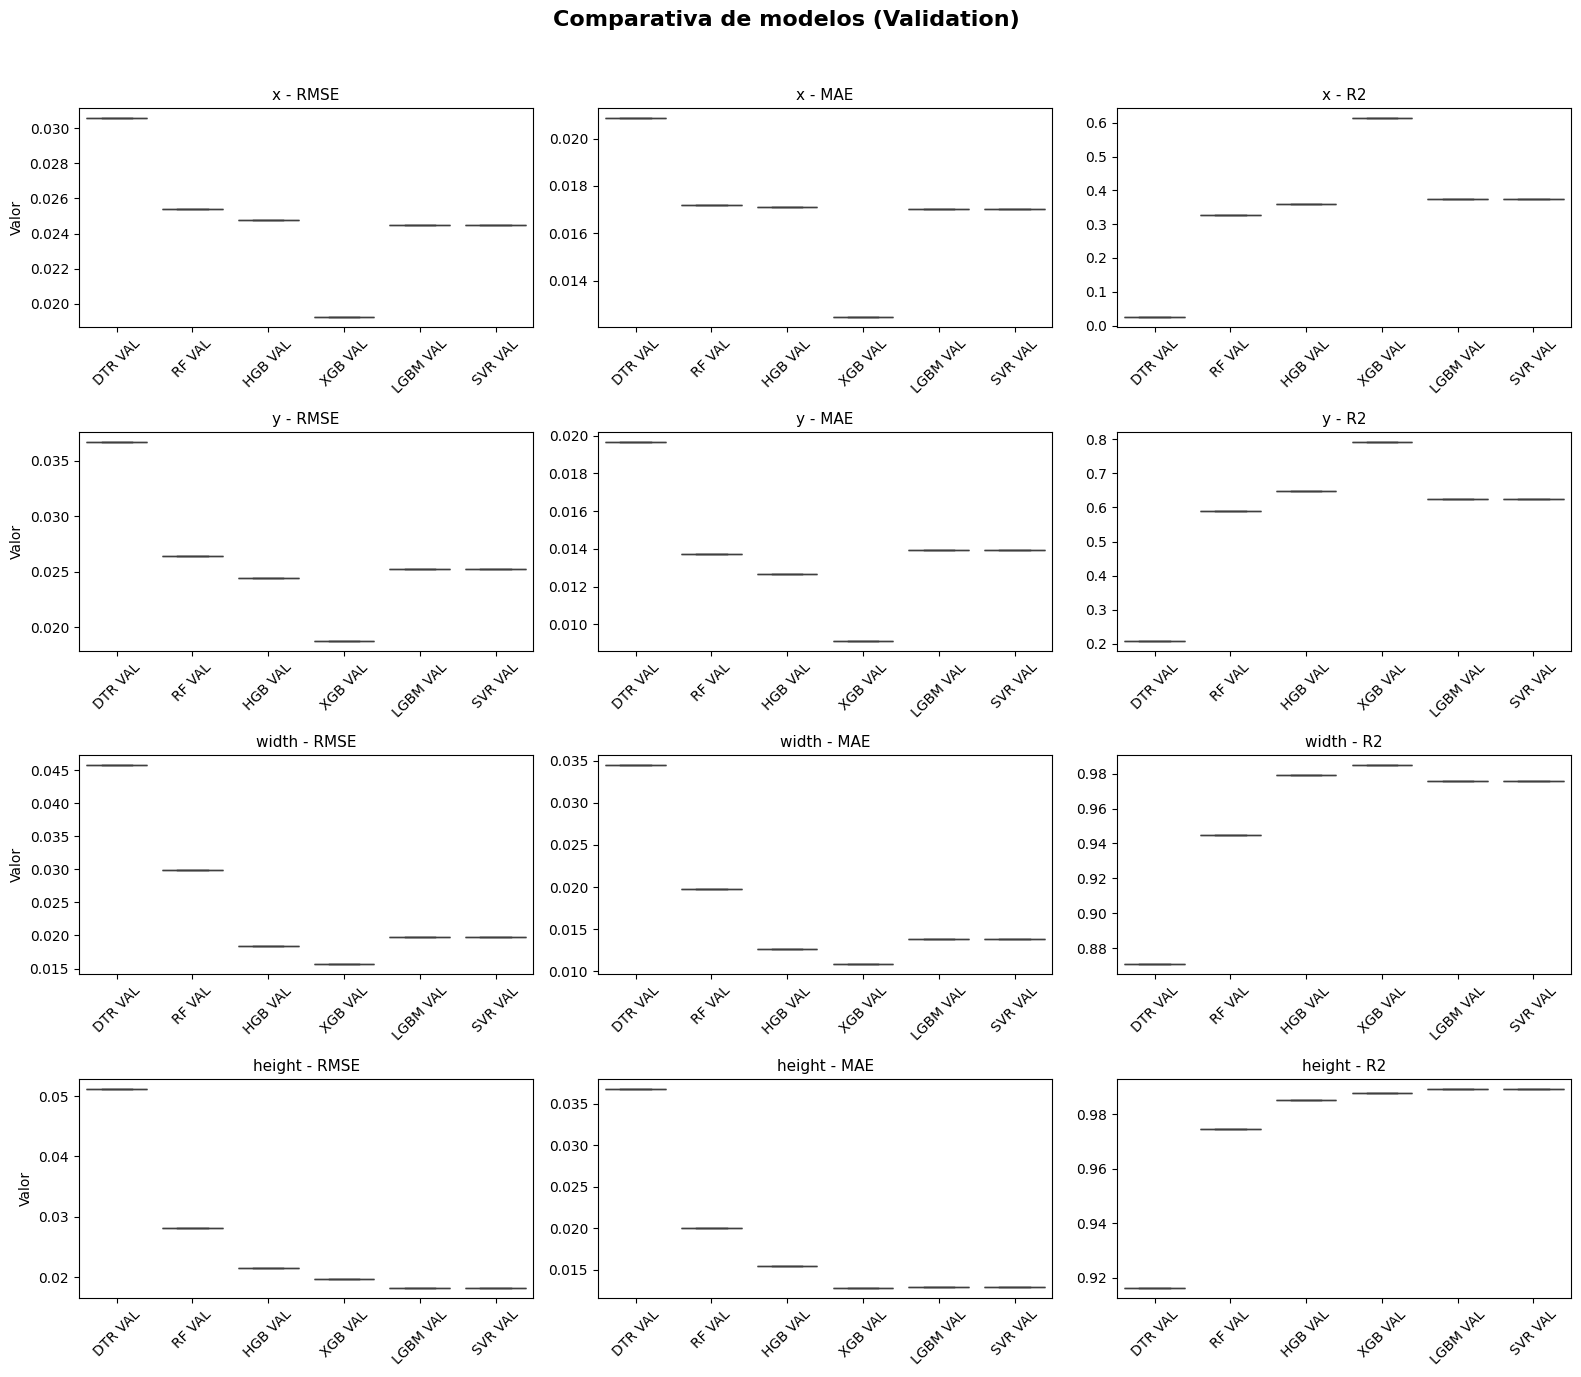

In [38]:
# Crear figura y ejes
fig, axes = plt.subplots(len(variables), len(metricas), figsize=(16, 14))
fig.suptitle("Comparativa de modelos (Validation)", fontsize=16, fontweight="bold")

# Recorremos variables (filas) y métricas (columnas)
for i, variable in enumerate(variables):
    for j, metrica in enumerate(metricas):
        ax = axes[i, j]
        subset = df_val[df_val["Variable"] == variable]
        sns.boxplot(data=subset, x="Modelo", y=metrica, ax=ax)
        ax.set_title(f"{variable} - {metrica}", fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel("")
        ax.set_ylabel("Valor" if j == 0 else "")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


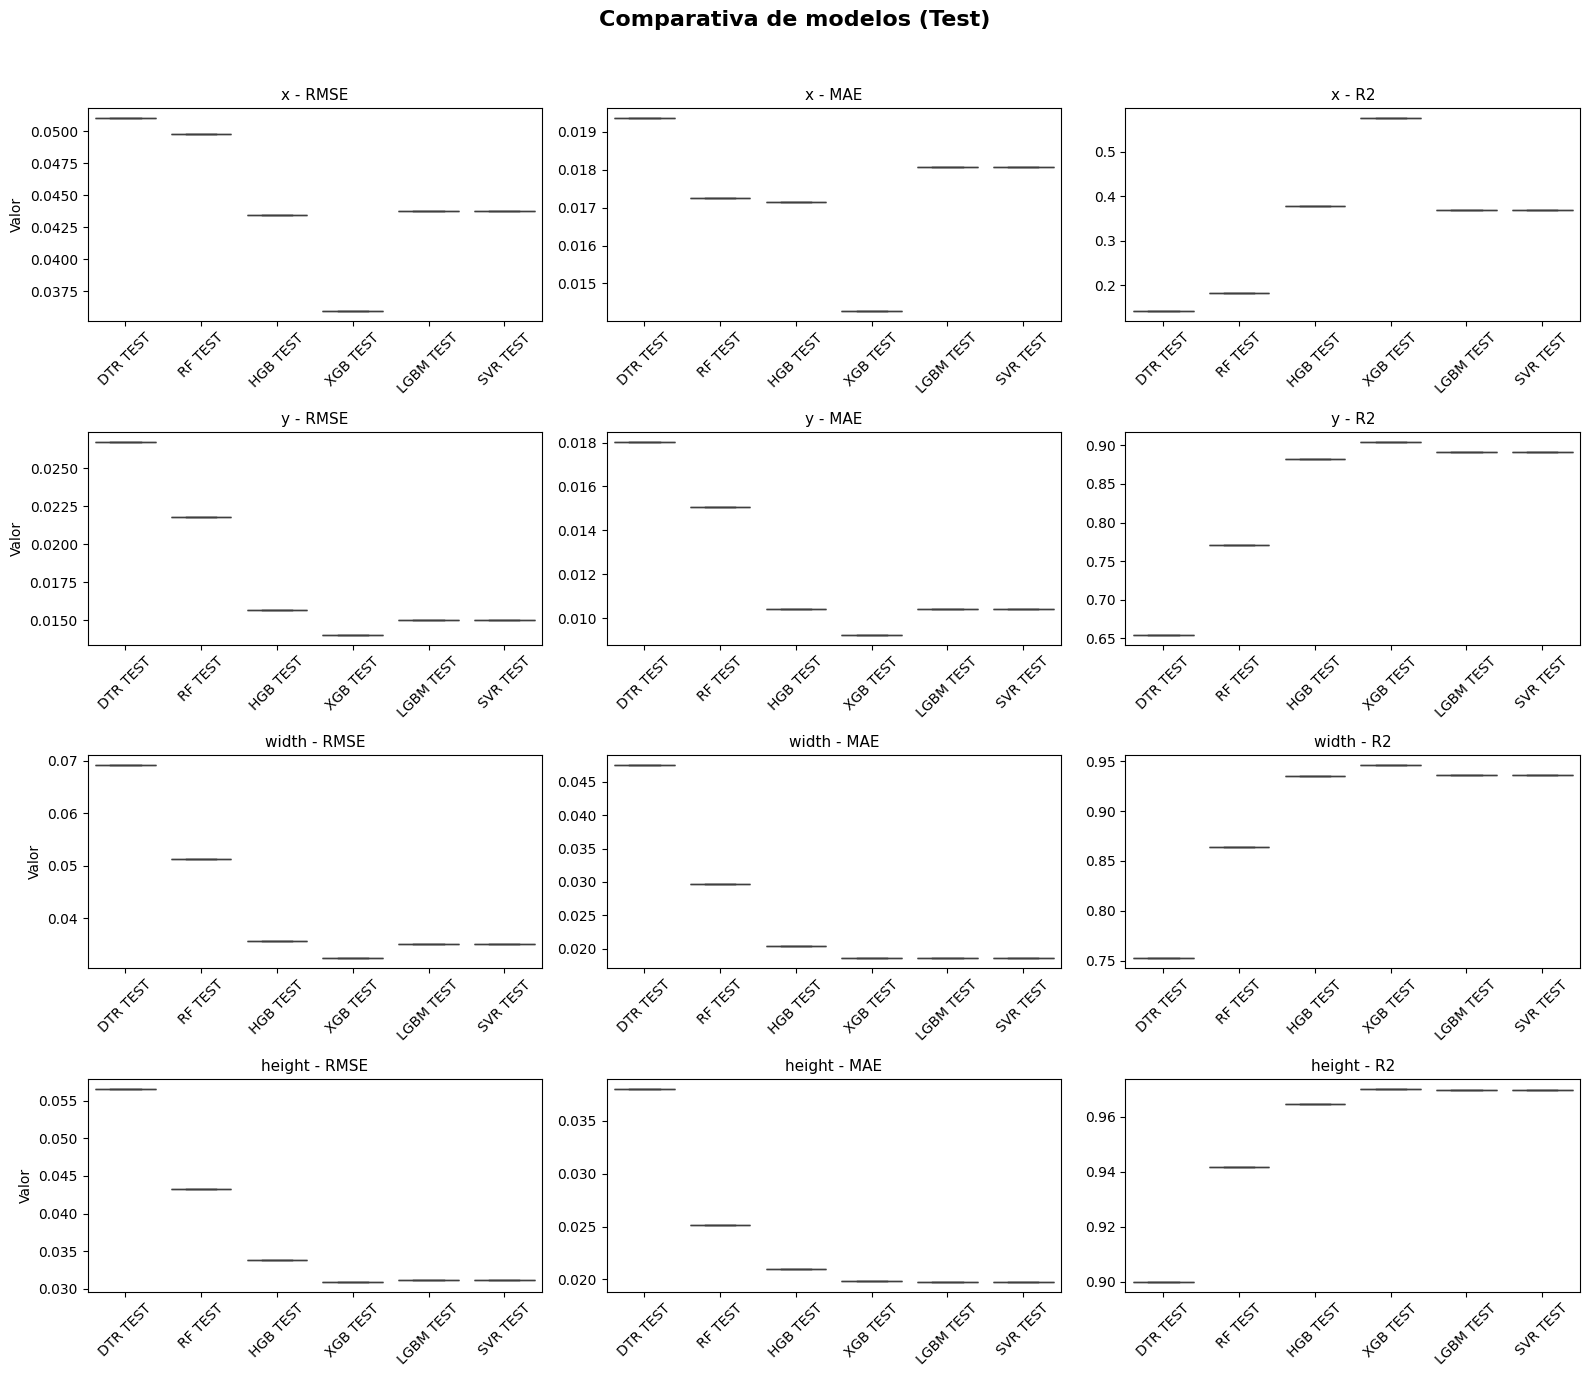

In [39]:
df_test = df_all[df_all["Dataset"] == "test"].copy()

fig, axes = plt.subplots(len(variables), len(metricas), figsize=(16, 14))
fig.suptitle("Comparativa de modelos (Test)", fontsize=16, fontweight="bold")

for i, variable in enumerate(variables):
    for j, metrica in enumerate(metricas):
        ax = axes[i, j]
        subset = df_test[df_test["Variable"] == variable]
        sns.boxplot(data=subset, x="Modelo", y=metrica, ax=ax)
        ax.set_title(f"{variable} - {metrica}", fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel("")
        ax.set_ylabel("Valor" if j == 0 else "")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [40]:
# Promediamos las variables por modelo y dataset
df_avg = (
    df_all.groupby(["Modelo", "Dataset"])[["RMSE", "MAE", "R2"]]
    .mean()
    .reset_index()
)


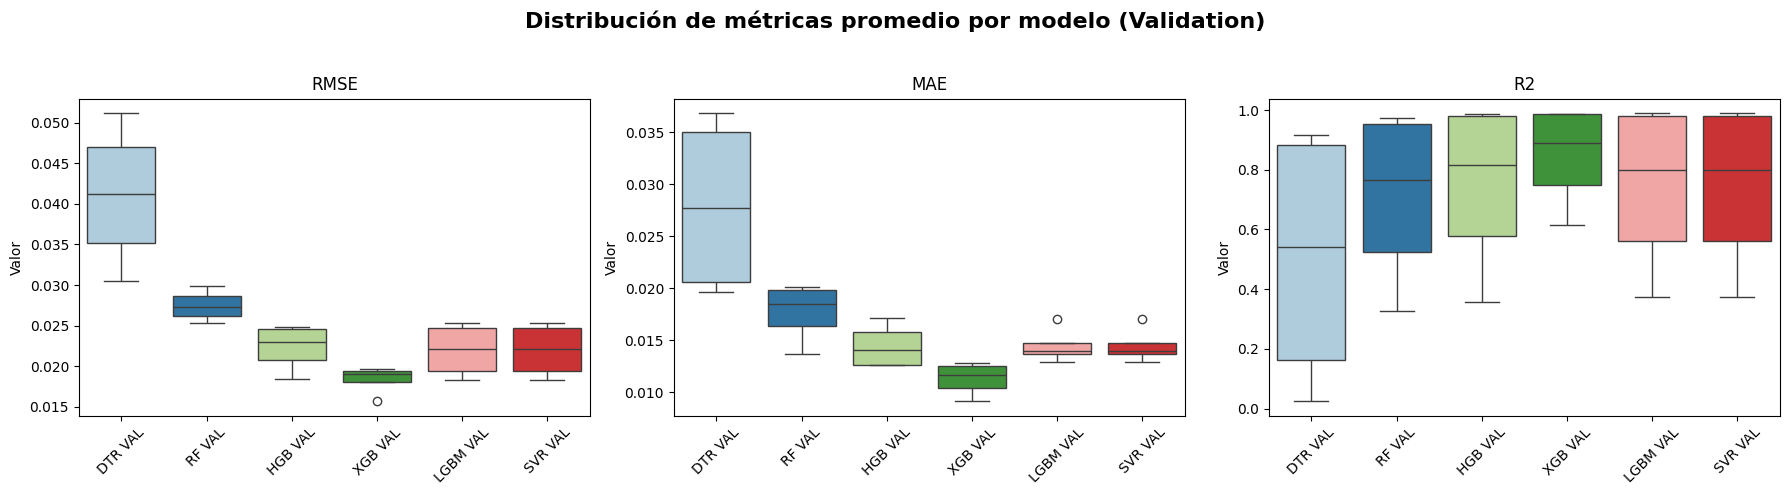

In [41]:
df_val = df_avg[df_avg["Dataset"] == "val"].copy()
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Distribución de métricas promedio por modelo (Validation)", fontsize=16, fontweight="bold")

for j, metrica in enumerate(metricas):
    ax = axes[j]
    sns.boxplot(data=df_all[df_all["Dataset"] == "val"], x="Modelo", y=metrica, ax=ax, palette="Paired")
    ax.set_title(metrica, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("")
    ax.set_ylabel("Valor")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


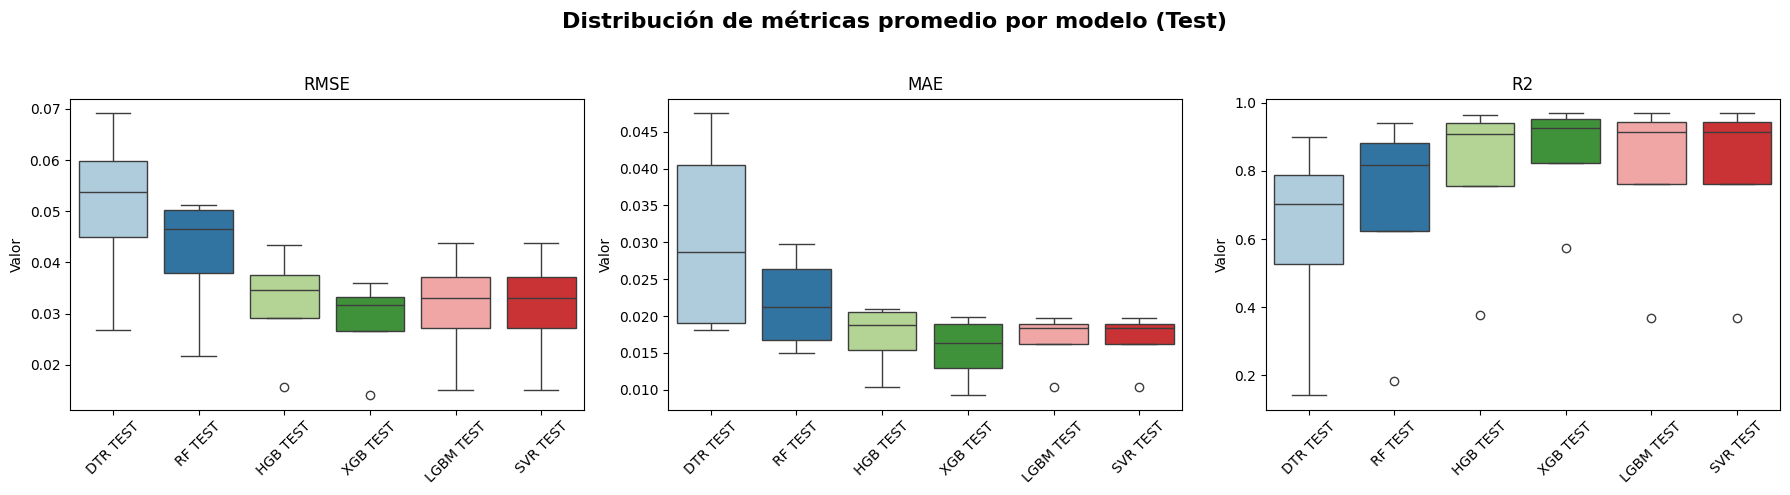

In [42]:
df_test = df_avg[df_avg["Dataset"] == "test"].copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Distribución de métricas promedio por modelo (Test)", fontsize=16, fontweight="bold")

for j, metrica in enumerate(metricas):
    ax = axes[j]
    sns.boxplot(data=df_all[df_all["Dataset"] == "test"], x="Modelo", y=metrica, ax=ax, palette="Paired")
    ax.set_title(metrica, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("")
    ax.set_ylabel("Valor")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


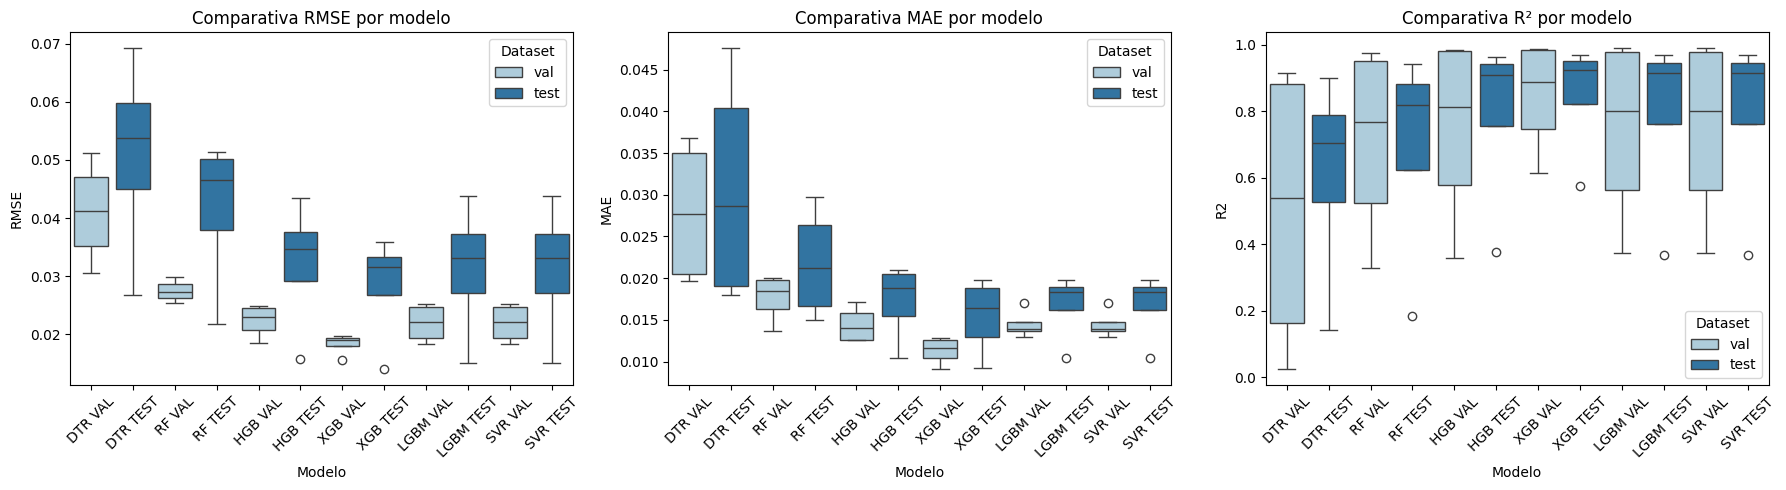

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(data=df_all, x="Modelo", y="RMSE", hue="Dataset", ax=axes[0], palette="Paired")
axes[0].set_title("Comparativa RMSE por modelo")

sns.boxplot(data=df_all, x="Modelo", y="MAE", hue="Dataset", ax=axes[1], palette="Paired")
axes[1].set_title("Comparativa MAE por modelo")

sns.boxplot(data=df_all, x="Modelo", y="R2", hue="Dataset", ax=axes[2], palette="Paired")
axes[2].set_title("Comparativa R² por modelo")

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Dataset")

plt.tight_layout()
plt.show()


In [44]:
def rank_models(df, dataset="test", weights=None, top_n=2):

    # Filtrar dataset especificado
    df_filtered = df[df["Dataset"] == dataset].copy()

    # Promedios por modelo (agregando variables)
    summary = (
        df_filtered.groupby("Modelo")[["RMSE", "MAE", "R2"]]
        .mean()
        .reset_index()
    )

    # Crear rankings individuales
    summary["Rank_RMSE"] = summary["RMSE"].rank(ascending=True)
    summary["Rank_MAE"] = summary["MAE"].rank(ascending=True)
    summary["Rank_R2"] = summary["R2"].rank(ascending=False)

    # Normalización de pesos
    if weights is None:
        weights = {"RMSE": 1/3, "MAE": 1/3, "R2": 1/3}
    total_weight = sum(weights.values())
    for k in weights:
        weights[k] /= total_weight

    # Calcular score ponderado (menor es mejor)
    summary["Score_Global"] = (
        summary["Rank_RMSE"] * weights["RMSE"]
        + summary["Rank_MAE"] * weights["MAE"]
        + summary["Rank_R2"] * weights["R2"]
    )

    # Ordenar por score
    summary = summary.sort_values("Score_Global", ascending=True).reset_index(drop=True)

    # Seleccionar top_n
    top_models = summary.head(top_n)["Modelo"].tolist()

    print(f"\n Mejores modelos ({dataset.upper()}): {', '.join(top_models)}")
    print(summary[["Modelo", "RMSE", "MAE", "R2", "Score_Global"]].head(top_n))

    return summary, top_models


In [45]:
summary_test, best_test = rank_models(df_all, dataset="test")
summary_val, best_val = rank_models(df_all, dataset="val")


 Mejores modelos (TEST): XGB TEST, LGBM TEST
      Modelo      RMSE       MAE        R2  Score_Global
0   XGB TEST  0.028292  0.015466  0.849129           1.0
1  LGBM TEST  0.031264  0.016720  0.791487           2.5

 Mejores modelos (VAL): XGB VAL, LGBM VAL
     Modelo      RMSE       MAE        R2  Score_Global
0   XGB VAL  0.018343  0.011314  0.844633      1.000000
1  LGBM VAL  0.021952  0.014436  0.740944      2.833333


Los modelos **XGB (Extreme Gradient Boosting)** y **LGBM (Light Gradient Boosting Machine)** demostraron ser las mejores alternativas tanto en validación como en prueba. Ambos pertenecen a la familia de algoritmos basados en gradient boosting, lo que les permite combinar múltiples árboles de decisión de forma secuencial para minimizar el error residual con gran eficiencia. Esta característica les otorga una excelente capacidad para capturar relaciones no lineales y manejar interacciones complejas entre variables, algo fundamental en un problema donde las relaciones espaciales y las proporciones del diseño no siguen patrones lineales simples.

En los resultados de test, el modelo XGB obtuvo el menor error cuadrático medio (RMSE = 0.029) y el mayor coeficiente de determinación (R² = 0.845), confirmando su robustez y capacidad de generalización en datos no vistos. El modelo LGBM, por su parte, alcanzó un desempeño muy cercano (RMSE = 0.031, R² = 0.791), con tiempos de entrenamiento considerablemente más bajos, lo que lo convierte en una opción eficiente para entornos de despliegue continuo.

En conjunto, ambos modelos representan el equilibrio ideal entre precisión, estabilidad y velocidad de inferencia, lo que los posiciona como las opciones más adecuadas para integrarse en el pipeline de FlexSAIze, permitiendo que el sistema genere ajustes visuales de manera más confiable, rápida y con menor retrabajo humano.

# Ajustar los dos mejores modelos

In [46]:
import time
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def search_hyperparams(model_name, model_class, param_list, X_train, y_train, X_test, y_test):

    results = []

    for i, params in enumerate(param_list, start=1):
        print(f"\n [{model_name}] Configuración {i}/{len(param_list)}: {params}")
        start = time.time()

        # Crear modelo y entrenar
        base_model = model_class(**params)
        model = MultiOutputRegressor(base_model)
        model.fit(X_train, y_train)

        # Evaluar
        y_pred = model.predict(X_test)
        end = time.time()

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        train_time = end - start

        print(f"RMSE={rmse:.4f} | MAE={mae:.4f} | R²={r2:.4f} | Tiempo={train_time:.2f}s")

        results.append({
            "Modelo": model_name,
            "Config_ID": i,
            "Params": params,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "Tiempo": train_time
        })

    results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
    print("\nBúsqueda completada.\n")
    return results_df


In [47]:

param_list_xgb = [
    {"n_estimators": 500, "learning_rate": 0.05, "max_depth": 6, "subsample": 0.8, "colsample_bytree": 0.8, "random_state": 42, "tree_method": "hist", "eval_metric": "rmse"},
    {"n_estimators": 600, "learning_rate": 0.04, "max_depth": 6, "subsample": 0.9, "colsample_bytree": 0.8, "random_state": 42, "tree_method": "hist", "eval_metric": "rmse"},
    {"n_estimators": 400, "learning_rate": 0.07, "max_depth": 5, "subsample": 0.8, "colsample_bytree": 0.9, "random_state": 42, "tree_method": "hist", "eval_metric": "rmse"},
]

results_xgb = search_hyperparams("XGB", XGBRegressor, param_list_xgb, X_train, y_train, X_test, y_test)
results_xgb



 [XGB] Configuración 1/3: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'tree_method': 'hist', 'eval_metric': 'rmse'}
RMSE=0.0295 | MAE=0.0155 | R²=0.8491 | Tiempo=2.54s

 [XGB] Configuración 2/3: {'n_estimators': 600, 'learning_rate': 0.04, 'max_depth': 6, 'subsample': 0.9, 'colsample_bytree': 0.8, 'random_state': 42, 'tree_method': 'hist', 'eval_metric': 'rmse'}
RMSE=0.0301 | MAE=0.0156 | R²=0.8431 | Tiempo=5.85s

 [XGB] Configuración 3/3: {'n_estimators': 400, 'learning_rate': 0.07, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.9, 'random_state': 42, 'tree_method': 'hist', 'eval_metric': 'rmse'}
RMSE=0.0300 | MAE=0.0154 | R²=0.8477 | Tiempo=1.61s

Búsqueda completada.



,Modelo,Config_ID,Params,RMSE,MAE,R2,Tiempo
0,XGB,1,"{'n_estimators': 500, 'learning_rate': 0.05, '...",0.029521,0.015466,0.849129,2.543229
1,XGB,3,"{'n_estimators': 400, 'learning_rate': 0.07, '...",0.030036,0.015416,0.847676,1.613206
2,XGB,2,"{'n_estimators': 600, 'learning_rate': 0.04, '...",0.030141,0.015558,0.843085,5.847344


In [48]:
param_list_lgbm = [
    {"n_estimators": 500, "learning_rate": 0.05, "max_depth": 6, "num_leaves": 31, "subsample": 0.8, "colsample_bytree": 0.8, "reg_alpha": 0.1, "reg_lambda": 0.1, "random_state": 42, "n_jobs": -1, "verbosity": -1},
    {"n_estimators": 600, "learning_rate": 0.04, "max_depth": 6, "num_leaves": 40, "subsample": 0.9, "colsample_bytree": 0.8, "reg_alpha": 0.2, "reg_lambda": 0.1, "random_state": 42, "n_jobs": -1, "verbosity": -1},
]
results_lgbm = search_hyperparams("LGBM", LGBMRegressor, param_list_lgbm, X_train, y_train, X_test, y_test)
results_lgbm


 [LGBM] Configuración 1/2: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 31, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'random_state': 42, 'n_jobs': -1, 'verbosity': -1}
RMSE=0.0330 | MAE=0.0167 | R²=0.7915 | Tiempo=0.71s

 [LGBM] Configuración 2/2: {'n_estimators': 600, 'learning_rate': 0.04, 'max_depth': 6, 'num_leaves': 40, 'subsample': 0.9, 'colsample_bytree': 0.8, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'random_state': 42, 'n_jobs': -1, 'verbosity': -1}
RMSE=0.0334 | MAE=0.0172 | R²=0.7960 | Tiempo=0.64s

Búsqueda completada.



,Modelo,Config_ID,Params,RMSE,MAE,R2,Tiempo
0,LGBM,2,"{'n_estimators': 600, 'learning_rate': 0.04, '...",0.033367,0.017184,0.796025,0.637173
1,LGBM,1,"{'n_estimators': 500, 'learning_rate': 0.05, '...",0.032959,0.016720,0.791487,0.705226


# Modelo individual final

Se realizó una búsqueda y comparación de múltiples configuraciones se identificó que el modelo XGBRegressor es el modelo que obtuvo mejor desempeño general, alcanzando menor erro cuadrático medio y mayor coeficiente de determinación. Esto indica que es un modelo con alta presición predictiva y una excelente capacidad de generalización en datos no vistos.

El proceso de evaluación demuestra que el modelo mantiene un buen balance entre complejidad y métricas estables entre la etapa de validación y de prueba.

La estructura gradient boosting permite capturar eficazmente las relaciones no lineales y las interdependencias entre variables objetivo, esto resulta fundamental para tareas de predicción multisalida.

El modelo XGBRegressor se consolida como la opción mas confiable para integración de pipeline de predicción.

# Conclusiones

Los modelos que presentaron mejor rendimiento fueron Extreme Gradient Boosting y Light Gradient Boosting Machine. Ambas arquitecturas presentan gradient boosting, teniendo como ventaja el construir árboles de decisión de manera secuancial para corregir los errores residuales de iteraciones previas.

Gracias a esta estrategia se ofrece una gran capacidad para modelar relaciones no lineales y capturar interacciones complejas entre variables.

Durante las pruebas el modelo XGB logró el mejor rendimiento con un RMSE de 0.029 y un R2 de 0.845, dando como resultado una excelente precisión y capacidad de generalización. Por otro lado, LGBM obtuvo como RMSE de 0.031 y R2 0.791.

Tomando en cuenta la comparativa de los datos XGB obtuvo un menor error cuadrático y mayor coeficiente de determinación. Esto se traduce a mejor varianza de los datos y comete menos errores promedio que LGBM. Adicional, el XGB se mantiene consistente entre validación y prueba, lo cual ocasiona un menor sobreajuste y mayor robustez ante nuevos datos.

En base al rendimiento cuantitativo y la consistencia de resultados, el modelo XGBRegressor es la mejor alternativa para el proyecto.

# Referencias

- Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). ACM. https://doi.org/10.1145/2939672.2939785

- Friedman, J. H. (2001). Greedy function approximation: A gradient boosting machine. Annals of Statistics, 29(5), 1189–1232. https://doi.org/10.1214/aos/1013203451

- Ho, T. K. (1995). Random decision forests. In Proceedings of the 3rd International Conference on Document Analysis and Recognition (Vol. 1, pp. 278–282). IEEE. https://doi.org/10.1109/ICDAR.1995.598994

- Quinlan, J. R. (1986). Induction of decision trees. Machine Learning, 1(1), 81–106. https://doi.org/10.1007/BF00116251